In [32]:
# read IGES file
# filename = '../data/Tetra_7431_python.vtu'
# outname  = '../data/Tetra_7431_python_solved.vtk'
filename = '../data/FEM/FEM2.vtu'
outname  = '../data/FEM/FEM2_solved.vtu'

In [33]:
import numpy as np
import pyvista as pv
from skfem import *
from skfem.models.elasticity import linear_elasticity, lame_parameters
from matplotlib import pyplot as plt

young = 20e9
poisson = 0.3

mesh = pv.read(filename)
points = mesh.points
tetras = mesh.cells.reshape(-1, 5)[:, 1:]

femesh = MeshTet(points.T, tetras.T)

e1 = ElementTetP1()
e = ElementVector(e1)
ib = Basis(femesh, e, MappingIsoparametric(femesh, e1), 3)

K = asm(linear_elasticity(*lame_parameters(young, poisson)), ib)

deg_xy = lambda x: np.rad2deg(np.arctan2(x[0], x[1]))

dofs = {
    'left' : ib.get_dofs(lambda x: deg_xy(x) < -29.99),
    'right' : ib.get_dofs(lambda x: deg_xy(x) > 29.99),
}

u = ib.zeros()
u[dofs['left'].nodal['u^1']] = -1e-4
u[dofs['right'].nodal['u^1']] = 1e-4

print_udofs = lambda key: print(key, dofs[key].nodal['u^1'].shape)

print_udofs('left')
print_udofs('right')

I = ib.complement_dofs(dofs)

u = solve(*condense(K, x=u, I=I))

sf = 1.0
femesh = femesh.translated(sf * u[ib.nodal_dofs])

print('Writing to', outname)
femesh.save(outname)


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


left (251,)
right (236,)
Writing to ../data/FEM/FEM2_solved.vtu


In [34]:
F = (K @ u).reshape(-1, 3)
F.sum(axis=0)

array([3.17701421e-12, 2.73450707e-12, 5.31452660e-12])

In [35]:
F_left = F[points[:, 0] < 0]
F_right = F[points[:, 0] > 0]

print('Left force:', F_left.sum(axis=0))
print('Right force:', F_right.sum(axis=0))

Left force: [-1.82956540e+02 -3.11474887e-03 -2.66453048e-03]
Right force: [1.82956540e+02 3.11474887e-03 2.66453049e-03]


In [36]:
F_expect = 2e2
scale = F_expect / F_right.sum(axis=0)[0]

u = scale * u

In [37]:
V = points
dV = u.reshape(-1, 3)
T = femesh.t.T

V.shape, dV.shape, T.shape

((9086, 3), (9086, 3), (46366, 4))

In [38]:
(V + dV)[:4]  - femesh.p.T[:4]

pyvista_ndarray([[ 9.59278025e-06,  3.79475443e-07, -1.50596470e-07],
                 [ 9.51959682e-06,  3.24822549e-07, -1.73409309e-07],
                 [ 9.47918895e-06,  2.04856784e-07, -9.18328085e-08],
                 [ 9.64058642e-06,  3.04993070e-07, -1.95097867e-08]])

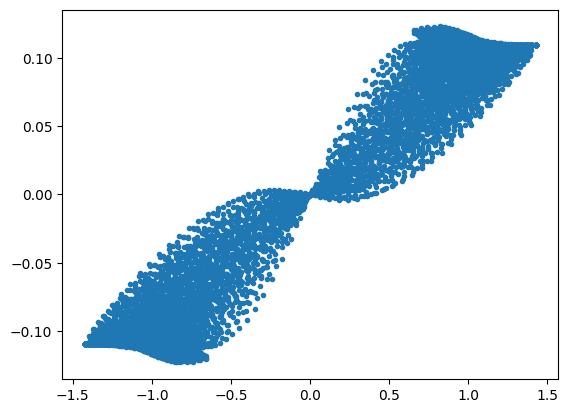

In [39]:
plt.plot(V[:, 0]*1e3, dV[:, 0]*1e3, '.')

## ミーゼス応力の計算

In [40]:
# V = V * 1e3
# dV = dV * 1e3


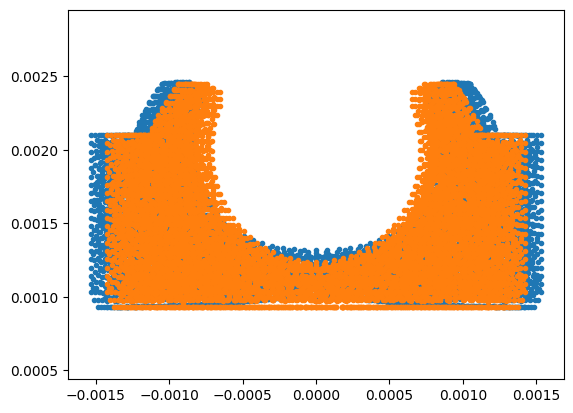

In [41]:
plt.plot(V.T[0] + dV.T[0], V.T[2] + dV.T[2], '.')
plt.plot(V.T[0], V.T[2], '.')

plt.axis('equal')
plt.show()


In [42]:
tetra_coords = lambda v: (v[1:] - v[0]).T

E = np.zeros((T.shape[0], 3, 3))
F = np.zeros((T.shape[0], 3, 3))

for t, i in zip(T, range(T.shape[0])):
    
    # 初期と変位後の座標を計算
    X = tetra_coords(V[t])
    Y = tetra_coords(V[t] + dV[t])
    
    # 変形勾配テンソルFを計算
    F[i] = np.linalg.solve(X.T, Y.T).T


In [43]:
F[10000]

(array([[ 1.01477647, -0.05246314,  0.00970957],
        [ 0.06351322,  0.98521768,  0.00252432],
        [-0.02254451,  0.00367995,  1.00007309]]),
 array([[ 0.01715673,  0.00462651, -0.0062664 ],
        [ 0.00462651, -0.0132901 ,  0.00282892],
        [-0.0062664 ,  0.00282892,  0.00012341]]))

In [44]:
# 右Cauchy-Greenひずみテンソル
C = np.einsum('...ij,...jk->...ik', F, F.transpose((0,2,1)))  # (m, 3, 3)

# Green-Lagrangeひずみテンソル
E = 0.5*(C - np.eye(3))  # (m, 3, 3)

lam = young * poisson / ((1 + poisson) * (1 - 2 * poisson))
mu = young / (2 * (1 + poisson))

I = np.eye(3)  # 単位行列
sigma = np.empty_like(E)  # Initialize stress tensor array
for i in range(E.shape[0]):
    eps = E[i]
    sigma[i] = lam * np.trace(eps) * I + 2 * mu * eps

In [45]:
# ボン・ミーゼス応力を計算
sigma_xx, sigma_yy, sigma_zz = sigma[:, 0, 0], sigma[:, 1, 1], sigma[:, 2, 2]
sigma_xy, sigma_yz, sigma_zx = sigma[:, 0, 1], sigma[:, 1, 2], sigma[:, 2, 0]

sigma_vm = np.sqrt(((sigma_xx - sigma_yy)**2 * 0.5 + 
                    (sigma_yy - sigma_zz)**2 * 0.5 + 
                    (sigma_zz - sigma_xx)**2 * 0.5 + 
                    (sigma_xy**2 + sigma_yz**2 + sigma_zx**2) * 3.0))  # (m,)

sigma_vm.shape

(46366,)

In [46]:
i = 10000
F[i], C[i], E[i], sigma[i], sigma_vm[i], F[i] - np.eye(3), C[i] - np.eye(3),

(array([[ 1.01477647, -0.05246314,  0.00970957],
        [ 0.06351322,  0.98521768,  0.00252432],
        [-0.02254451,  0.00367995,  1.00007309]]),
 array([[ 1.03261794,  0.01278861, -0.01336043],
        [ 0.01278861,  0.97469418,  0.00471818],
        [-0.01336043,  0.00471818,  1.00066797]]),
 array([[ 0.01630897,  0.00639431, -0.00668021],
        [ 0.00639431, -0.01265291,  0.00235909],
        [-0.00668021,  0.00235909,  0.00033399]]),
 array([[ 2.96946205e+08,  9.83739609e+07, -1.02772515e+08],
        [ 9.83739609e+07, -1.48621129e+08,  3.62937142e+07],
        [-1.02772515e+08,  3.62937142e+07,  5.11772698e+07]]),
 462705725.5738367,
 array([[ 1.47764677e-02, -5.24631412e-02,  9.70956845e-03],
        [ 6.35132183e-02, -1.47823176e-02,  2.52431737e-03],
        [-2.25445148e-02,  3.67995393e-03,  7.30860631e-05]]),
 array([[ 0.03261794,  0.01278861, -0.01336043],
        [ 0.01278861, -0.02530582,  0.00471818],
        [-0.01336043,  0.00471818,  0.00066797]]))

In [49]:
# Create a PyVista mesh object from the tetrahedral mesh
mesh = pv.read(outname)
mesh.points = V

# Add the displacement and von Mises stress as point data
mesh.cell_data['von_mises_stress'] = sigma_vm
mesh.point_data['von_mises_stress'] = mesh.cell_data_to_point_data()['von_mises_stress']
mesh.point_data['deformation'] = dV

# delete cell data
del mesh.cell_data['von_mises_stress']

# mesh.cell_data['F'] = F[:,0,0]
# mesh.cell_data['C'] = C[:,0,0]
# mesh.cell_data['E'] = E[:,0,0]
# mesh.cell_data['sigma'] = sigma.T[0,0]

# Write the mesh to a VTK file
print('Rewriting to', outname)
mesh.save(outname, binary=False)

Rewriting to ../data/FEM/FEM2_solved.vtu


In [48]:
# mesh.cell_data['von_mises_stress']

## 乱数を使って任意の保持器のFEM解析


In [20]:
from morphing.morphing import CageParameter, Brg
import numpy as np

In [21]:
np.random.seed(0)
params = np.random.randn(100, 10) / 3
params[params<-1] = -1
params[params>1] = 1
params[:2]

array([[ 0.58801745,  0.13338574,  0.32624599,  0.7469644 ,  0.62251933,
        -0.32575929,  0.31669614, -0.0504524 , -0.03440628,  0.13686617],
       [ 0.04801452,  0.48475784,  0.25367924,  0.04055834,  0.14795441,
         0.11122478,  0.49802636, -0.06838609,  0.1043559 , -0.28469858]])

In [22]:
r0 = lambda dr: 2.35e-3 + dr
r1 = lambda dr: 2.85e-3 + dr
r0s = r0(params[:, 0] * 0.2e-3)
r1s = r1(params[:, 1] * 0.2e-3)
drs = r1s - r0s
h0 = lambda dh: 0.93e-3 + dh
h1 = lambda dh: 2.10e-3 + dh
h0s = h0(params[:, 2] * 0.2e-3)
h1s = h1(params[:, 3] * 0.2e-3)
bevel = lambda r: 0.1 * drs * r
bevels = bevel(params[:, 4]+2)
pocket_r = lambda dr: 0.825e-3 + dr
pocket_rs = pocket_r(params[:, 5] * 1e-6)
neck_x = lambda dx: 1.70e-3 + dx
neck_xs = neck_x(params[:, 6] * 20e-6)
neck_r = lambda dr: 1.20e-3 + dr
neck_rs = neck_r(params[:, 7] * 20e-6)
neck_h = lambda dh: 2.45e-3 + dh
neck_hs = neck_h(params[:, 8] * 100e-6)
neck_dh = lambda r: (neck_hs - h1s) * r * 0.1
neck_dhs = neck_dh(params[:, 9]+2)

In [23]:
cage = CageParameter(2.345e-3,2.850e-3,0.93e-3,2.10e-3,0.10e-3,0.825e-3,1.70e-3,1.20e-3,2.45e-3,0.152e-3)
brg  = Brg("../data/FEM/FEM2.vtu", "../data/FEM/index2.xml", cage)
brg_std = brg.std()


In [24]:
new_cage = lambda i: CageParameter(r0s[i], r1s[i], h0s[i], h1s[i], bevels[i], pocket_rs[i], neck_xs[i], neck_rs[i], neck_hs[i], neck_dhs[i])
brg.reload_cage(new_cage(10), 50, 10)


In [25]:
# for i in range(len(params)):
    
#     brg.reload_cage(new_cage(i), 100, 30)
    
#     for _ in range(50):
#         brg.scale(1.0 / brg_std)
#         success = brg.flip_negative_volume(0.1)
#         brg.scale(brg_std)
#         brg.normalize_center()
#         if success:
#             break

#     finish = False

#     for _ in range(50):
#         brg.scale(1.0 / brg_std)
#         success = brg.flip_negative_volume_only_sphire(0.01)
#         brg.scale(brg_std)
#         brg.normalize_center()
#         if success:
#             finish = True
#             break
    
#     brg.write_vtk_from_base("../data/FEM/FEM2.vtu", f"../data/FEM/random/FEM2_{i}.vtu")


In [62]:
# for i in range(len(params)):
mesh = pv.read("../data/FEM/FEM2.vtu")

for iteration in range(len(params)):
    brg.reload_cage(new_cage(iteration), 50, 20)
    
    points = np.array(brg.get_points_as_list())
    
    femesh = MeshTet(points.T, tetras.T)

    e1 = ElementTetP1()
    e = ElementVector(e1)
    ib = Basis(femesh, e, MappingIsoparametric(femesh, e1), 3)

    K = asm(linear_elasticity(*lame_parameters(young, poisson)), ib)

    u = ib.zeros()
    u[dofs['left'].nodal['u^1']] = -1e-4
    u[dofs['right'].nodal['u^1']] = 1e-4

    I = ib.complement_dofs(dofs)
    u = solve(*condense(K, x=u, I=I))
    
    F = (K @ u).reshape(-1, 3)
    F_right = F[points[:, 0] > 0]
    scale = F_expect / F_right.sum(axis=0)[0]
    u = scale * u
    
    V = points
    dV = u.reshape(-1, 3)
    
    F = np.zeros((T.shape[0], 3, 3))
    for t, i in zip(T, range(T.shape[0])):
        X = tetra_coords(V[t])
        Y = tetra_coords(V[t] + dV[t])
        F[i] = np.linalg.solve(X.T, Y.T).T
    
    C = np.einsum('...ij,...jk->...ik', F, F.transpose((0,2,1)))  # (m, 3, 3)
    E = 0.5*(C - np.eye(3))  # (m, 3, 3)
    I = np.eye(3)  # 単位行列
    for i in range(E.shape[0]):
        eps = E[i]
        sigma[i] = lam * np.trace(eps) * I + 2 * mu * eps
    sigma_xx, sigma_yy, sigma_zz = sigma[:, 0, 0], sigma[:, 1, 1], sigma[:, 2, 2]
    sigma_vm = np.sqrt(((sigma_xx - sigma_yy)**2 * 0.5 +
                        (sigma_yy - sigma_zz)**2 * 0.5 +
                        (sigma_zz - sigma_xx)**2 * 0.5 +
                        (sigma_xy**2 + sigma_yz**2 + sigma_zx**2) * 3.0))  # (m,)
    mesh.points = V
    mesh.cell_data['von_mises_stress'] = sigma_vm
    mesh.point_data['von_mises_stress'] = mesh.cell_data_to_point_data()['von_mises_stress']
    mesh.point_data['deformation'] = dV
    del mesh.cell_data['von_mises_stress']
    mesh.save(f"../data/FEM/random/FEM2_{iteration}.vtu", binary=False)
    print(f"../data/FEM/random/FEM2_{iteration}.vtu")
    


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.
Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_0.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_1.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_2.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_3.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_4.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_5.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_6.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_7.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_8.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_9.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_10.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_11.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_12.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_13.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_14.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_15.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_16.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_17.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_18.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_19.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_20.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_21.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_22.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_23.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_24.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_25.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_26.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_27.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_28.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_29.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_30.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_31.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_32.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_33.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_34.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_35.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_36.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_37.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_38.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_39.vtu
../data/FEM/random/FEM2_40.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.
Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_41.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_42.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_43.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_44.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_45.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_46.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_47.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_48.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_49.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_50.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_51.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_52.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_53.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_54.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_55.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_56.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_57.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_58.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_59.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_60.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_61.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_62.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_63.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_64.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_65.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_66.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_67.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_68.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_69.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_70.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_71.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_72.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_73.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_74.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_75.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_76.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_77.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_78.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_79.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_80.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_81.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_82.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_83.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_84.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_85.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_86.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_87.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_88.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_89.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_90.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_91.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_92.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_93.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_94.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_95.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_96.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_97.vtu


Transforming over 1000 vertices to C_CONTIGUOUS.
Transforming over 1000 elements to C_CONTIGUOUS.


../data/FEM/random/FEM2_98.vtu
../data/FEM/random/FEM2_99.vtu
